<center>
<h2>Texmining 2021</h2>
<h3>Práctico: Clustering de palabras</h3>
</center>
</left>
<h3>Alumno: Martín Hunziker</h3>


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from sklearn.feature_extraction import DictVectorizer

from time import time 
from gensim.models.phrases import Phrases, Phraser
import re 

In [50]:
import sys
print(sys.executable)

C:\Users\mhunz\.conda\envs\NLP\python.exe


### Lectura de datos y pipeline de spacy

In [51]:
#Cargamos el large language model de spacy para disponer de la vectorizacion de las palabras
nlp = spacy.load("es_core_news_sm", disable=['ner']) # # modelo chico = "es_core_news_sm" 
lemmatizer = nlp.get_pipe("lemmatizer")
print(lemmatizer.mode)  # 'rule'

rule


In [52]:
filename = "lavoztextodump.txt"
text_file = open(filename, "r", encoding = 'utf-8-sig')
dataset = text_file.read()
text_file.close()

Para perfeccionar la lematización del spacy si trabajará con la lista de lematiazion del site:
https://github.com/michmech/lemmatization-lists


In [53]:
   
lemma_file = open("lemmatization-es.txt", "r",encoding = 'utf-8-sig')
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]
        
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word


In [54]:
len(dataset)

34140489

### Leemos parcialmente el corpus por limitación de memoria

In [55]:
nlp.max_length = 10000010
data =dataset[0:10000000]


### Criterios de selección de palabras del corpus

1. Solamente consideraremos las oraciones de largo mayor a 10
2. Consideremos las palabras alfabéticas
3. Eliminamos las palabras que sean números
4. Definimos Límites de cantidad máxima de palabras con la variables qPalabraMax
 

In [56]:
### Process data
doc = nlp(data) #34.140.489

In [57]:
## Saving DOC
doc.to_disk("./trained/doc")
doc1=doc

In [58]:
## Reading previus DOC 

#from spacy.tokens import Doc
#from spacy.vocab import Vocab
#doc = Doc(Vocab()).from_disk("./trained/doc")

In [59]:
sentences =[]
for sent in doc.sents:
    if len(sent) > 10:
        sentences.append([token.text for token in sent]) 

In [60]:
sents = [sent for sent in doc.sents if len(sent) > 10]

words = []
words_lemma = []
lstsents_lemma = []
lstsents = []
for sent in sents:
    lstsent_lemma = []
    lstsent = []
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(lemmatize(word.lemma_))
            lstsent.append(word.text)
            lstsent_lemma.append(lemmatize(word.lemma_))
    lstsents_lemma.append(lstsent_lemma)
    lstsents .append(lstsent)   
counts = Counter(words_lemma)

Hacemos el histograma de las 50 lemmas más coumnes para observar la distribución

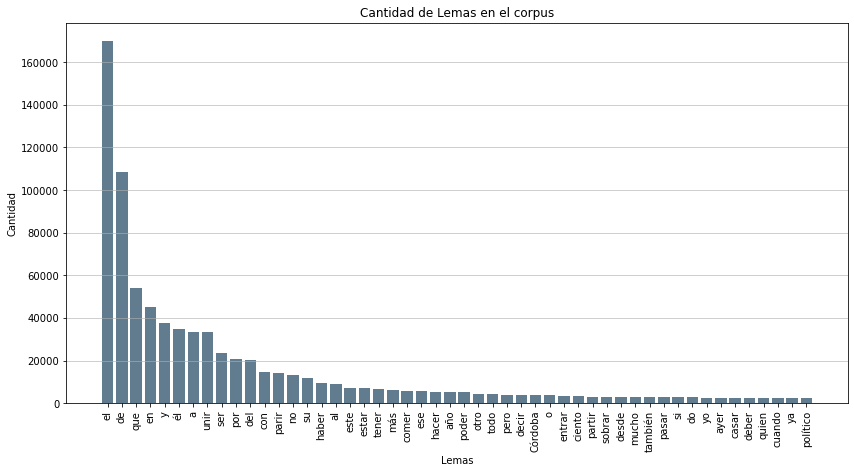

In [61]:
word_comm=pd.DataFrame(counts.most_common(10000))

plt.figure(figsize=(14, 7))

plt.bar(word_comm[0][0:50], word_comm[1][0:50],color='#607c8e',)

plt.title('Cantidad de Lemas en el corpus')
plt.xlabel('Lemas')
plt.ylabel('Cantidad')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=90)

plt.show()

Creamos un diccionario de palabras considerando las que ocurren mas veces:
   1. ocurren pocas veces (ranking 500)
   2. son numeros
   
y le adicionamos los features de cada vez que aparece.

Los features considerados son:

 * Part-Of-Speech POS word.pos_ (ADJ: adjective, ADP: adposition, ADV: adverb, AUX: auxiliary verb, CONJ: coordinating conjunction, DET: determiner, INTJ: interjection, NOUN: noun, NUM: numeral, PART: particle, PRON: pronoun,PROPN: proper noun,PUNCT: punctuation, SCONJ: subordinating conjunction, SYM: symbol, VERB: verb, X: other)
 * Dependencia semántica entre las palabras (word.dep_)
 * Morfología de la palabra
 * Agregamos los contextos, sin orden (ventana de 1 palabra).
 * Cargamos como atributo el vector de sapcy para cada palabra


In [62]:
limiteW=word_comm[1][1000] 
limiteW

175

In [63]:
dicc = {}
list_dicc = {}
word_id = 0
qPalabraMax = limiteW  
qPalabraConjMax = limiteW /4

for word in words:
    #print(word)
    w = lemmatize(word.lemma_)
    #print(word,word.is_alpha, not(str.isdigit(w)) , counts[w],counts[w] < qPalabraMax)
    if (word.is_alpha and counts[w] > qPalabraMax):
        if not w in dicc:
            features = {}
        else:
            features = dicc[w]
            
            
        pos = "POS__" + word.pos_
        if not pos in features:
            features[pos] = 0
        features[pos] += 1

        dep = "DEP__" + word.dep_
        if not dep in features:
            features[dep] = 0
        features[dep] += 1

        morf = "MRF__" + str(word.morph)
        if not morf in features:
            features[morf] = 0
        features[morf] += 1
        
        
        
        # Contexto
        if not word.i == 0:
            context_izq = doc[word.i - 1]
            c_izq = lemmatize(context_izq.lemma_)
            if context_izq.is_alpha and counts[c_izq] > qPalabraConjMax:
                if str.isdigit(c_izq):
                    c_izq = "NUM__"
                if not c_izq in features:
                    features[c_izq] = 0
                features[c_izq] += 1

        if not word.i < len(doc):
            context_der = doc[word.i + 1]
            c_der = lemmatize(context_der.lemma_)
            if context_der.is_alpha and counts[c_der] > qPalabraConjMax:
                if str.isdigit(c_der):
                    c_der = "NUM__"
                if not c_der in features:
                    features[c_der] = 0
                features[c_der] += 1

        tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
        if not tripla in features:
            features[tripla] = 0
        features[tripla] += 1

        word_id += 1

        dicc[w] = features


Separamos las palabras y sus features

In [64]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [65]:
## guardamos los archivos a pickle

filename = "trained/dicc.pickle"
fileObj = open(filename, 'wb')
pickle.dump(dicc, fileObj)
fileObj.close()

filename = "trained/features.pickle"
fileObj = open(filename, 'wb')
pickle.dump(features, fileObj)
fileObj.close()

filename = "trained/keys.pickle"
fileObj = open(filename, 'wb')
pickle.dump(key_words, fileObj)
fileObj.close()

Vectorizamos y normalizamos la matriz por filas

In [66]:
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)
matrix_normed = matrix / matrix.max(axis=0)

#### Reducimos la dimensionalidad quitando aquellas columnas que tengan poca varianza

In [67]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [68]:
VarianzaMin = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < VarianzaMin), axis=1)

#### Reducimos la dimensionalidad aplicando el t-distributed Stochastic Neighbor Embedding.

In [69]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

C:\Users\mhunz\.conda\envs\NLP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mhunz\.conda\envs\NLP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [70]:
DF_matrix_dicc2d = pd.DataFrame(matrix_dicc2d, columns=["x", "y"])
DF_matrix_dicc2d['word'] = pd.DataFrame.from_dict(key_words,orient='index').reset_index()['index']


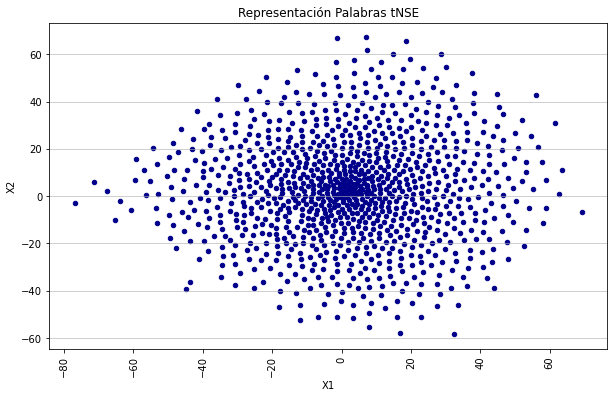

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
DF_matrix_dicc2d.plot.scatter(ax=ax,x='x',y='y', c='DarkBlue',figsize=(10, 6))

plt.title('Representación Palabras tNSE')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=90)
plt.show()

In [72]:
def PlotWordRadius(Sword, radio,DS):
    if 'Cluster' not in DS:
        DS['Cluster'] = 0
        
    dword=DS[DS.word == Sword]
    x = dword.x.values[0]
    y = dword.y.values[0]

    x_liminf = x-radio
    x_limsup = x+radio
    y_liminf = y-radio
    y_limsup = y+radio

    df_plot = DS[(x_liminf <= DS['x']) & (DS['x']<= x_limsup)&\
                               (y_liminf <= DS['y']) & (DS['y']<= y_limsup)]

    fig, ax = plt.subplots(figsize=(12, 8))
   
    scatter = ax.scatter(df_plot.x, df_plot.y, c=df_plot.Cluster)
    
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Cluster")
    ax.add_artist(legend1)

    
    plt.title('Representación Palabras tNSE' + ' palabra= ' + Sword + ' Radio= ' + str(radio) )
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(x_liminf, x_limsup)
    plt.ylim(y_liminf, y_limsup)

    for id, vector in df_plot.iterrows():
           ax.annotate(vector['word'],vector[['x', 'y']],textcoords="offset points",xytext=(0,5),ha='center')


    plt.grid(axis='y', alpha=0.75)
    plt.xticks(rotation=90)
    plt.show()

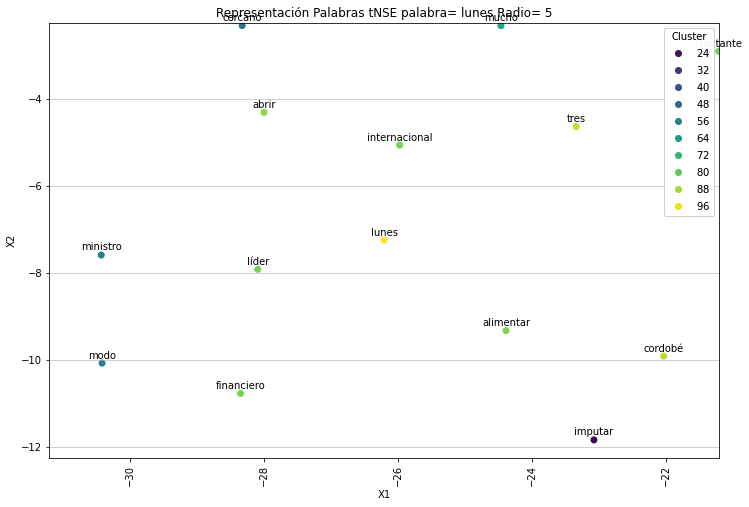

In [113]:
Sword = 'lunes'

PlotWordRadius(Sword, 5, DF_matrix_dicc2d)

### Clustering

In [74]:
def clustering(k, DS_Cluster):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(DS_Cluster, True)
    return clusters

In [75]:
nCluster = 100
clt =  clustering(nCluster,red_matrix)


In [76]:
# Exportando a pickle
filename = "trained/clt.pickle"
fileObj = open(filename, 'wb')
pickle.dump(clt, fileObj)
fileObj.close()


In [77]:
DF_matrix_dicc2d['Cluster']=clt

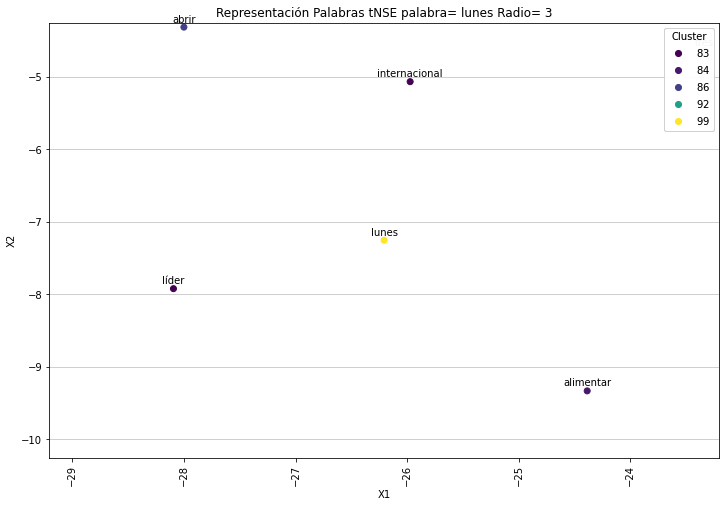

In [114]:
PlotWordRadius(Sword, 3, DF_matrix_dicc2d)

In [79]:
def ClusterValues( Sword,DS):
    cluster = DS[DS.word == Sword].Cluster.values[0]
    print(DS[DS.Cluster==cluster].word.to_numpy())


In [80]:
# Stopwords
Sword = 'de'
ClusterValues(Sword,DF_matrix_dicc2d )

['él' 'que' 'sostener' 'a' 'ser' 'y' 'no' 'sin' 'hacer' 'estar' 'tener'
 'en' 'de' 'asegurar' 'del' 'llevar' 'juntar' 'sino' 'tanto' 'yo'
 'siempre' 'cuando' 'ya' 'más' 'parir' 'cambiar' 'con' 'acordar' 'seguir'
 'al' 'después' 'tú' 'ayudar' 'sólo' 'por' 'trabajar' 'si' 'crecer'
 'poder' 'o' 'manejar' 'mantener' 'tomar' 'sumar' 'reclamar' 'mejorar'
 'pedir' 'advertir' 'comer' 'llegar' 'porque' 'empezar' 'continuar' 'dar'
 'morir' 'anticipar' 'contar' 'recién' 'pasar' 'salir' 'quedar' 'deber'
 'esperar' 'admitir' 'mucho' 'evitar' 'brindar' 'proponer' 'participar'
 'generar' 'ni' 'donde' 'manifestar' 'argumentar' 'durante' 'hasta'
 'aceptar' 'comenzar' 'aparecer' 'relatar' 'depender' 'ocurrir' 'subir'
 'afirmar' 'tal' 'e' 'aumentar' 'recibir' 'funcionar' 'apuntar' 'todavía'
 'tras' 'recuperar' 'cerrar' 'cercar' 'indicar' 'perder' 'aplicar'
 'Francisco' 'permitir' 'cualquiera' 'buscar' 'surgir' 'informar'
 'concluir' 'mientras' 'entonces' 'denunciar' 'intentar' 'crisis'
 'estrategia' 'con

In [81]:
# Verbos
Sword = 'ayudar'
ClusterValues(Sword,DF_matrix_dicc2d )

['él' 'que' 'sostener' 'a' 'ser' 'y' 'no' 'sin' 'hacer' 'estar' 'tener'
 'en' 'de' 'asegurar' 'del' 'llevar' 'juntar' 'sino' 'tanto' 'yo'
 'siempre' 'cuando' 'ya' 'más' 'parir' 'cambiar' 'con' 'acordar' 'seguir'
 'al' 'después' 'tú' 'ayudar' 'sólo' 'por' 'trabajar' 'si' 'crecer'
 'poder' 'o' 'manejar' 'mantener' 'tomar' 'sumar' 'reclamar' 'mejorar'
 'pedir' 'advertir' 'comer' 'llegar' 'porque' 'empezar' 'continuar' 'dar'
 'morir' 'anticipar' 'contar' 'recién' 'pasar' 'salir' 'quedar' 'deber'
 'esperar' 'admitir' 'mucho' 'evitar' 'brindar' 'proponer' 'participar'
 'generar' 'ni' 'donde' 'manifestar' 'argumentar' 'durante' 'hasta'
 'aceptar' 'comenzar' 'aparecer' 'relatar' 'depender' 'ocurrir' 'subir'
 'afirmar' 'tal' 'e' 'aumentar' 'recibir' 'funcionar' 'apuntar' 'todavía'
 'tras' 'recuperar' 'cerrar' 'cercar' 'indicar' 'perder' 'aplicar'
 'Francisco' 'permitir' 'cualquiera' 'buscar' 'surgir' 'informar'
 'concluir' 'mientras' 'entonces' 'denunciar' 'intentar' 'crisis'
 'estrategia' 'con

In [82]:
# Politica
Sword ="Giacomino"
ClusterValues(Sword,DF_matrix_dicc2d )

['Educación' 'Unidos' 'Provincia' 'Nación' 'Justicia' 'Secretaría'
 'Legislatura' 'UNC' 'Casa' 'Unión' 'Comercio' 'Voz' 'Aires' 'Central'
 'Sota' 'Schiaretti' 'Mestre' 'UCR' 'Municipalidad' 'Giacomino' 'Iglesia'
 'Policía' 'Diputados' 'Presidenta' 'Salud']


In [83]:
# Fechas
Sword ="lunes"
ClusterValues(Sword,DF_matrix_dicc2d )

['miércoles' 'septiembre' 'martes' 'diciembre' 'viernes' 'octubre' 'lunes'
 'abril' 'agostar' 'jueves' 'marzo' 'enero' 'junio' 'julio' 'domingo'
 'mayar']


### Embeddings: Word2Vec



### Training the model¶


In [84]:
import multiprocessing

from gensim.models import Word2Vec

In [115]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

In [116]:
len(lstsents)

59231

In [117]:
phrases = Phrases(lstsents_lemma, min_count=10, progress_per=1000)
bigram = Phraser(phrases)
sentences = bigram[lstsents]


### The parameters:


In [118]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     sample=6e-5,
                     vector_size = 300,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Building the Vocabulary Table:


In [119]:
# Sentence options: lstsents_lemma, lstsents

t = time()

w2v_model.build_vocab(sentences, progress_per=100000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


### Training of the model:


In [120]:
t = time()

w2v_model.train(lstsents, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.4 mins


In [121]:
w2v_model.wv.most_similar(positive=["de"])

[('la', 0.5020110011100769),
 ('del', 0.4423753321170807),
 ('y', 0.4240289628505707),
 ('en', 0.3828110992908478),
 ('Con', 0.306803435087204),
 ('En', 0.3015977442264557),
 ('obtiene', 0.2996242344379425),
 ('La', 0.2914838194847107),
 ('fronteriza', 0.2890869081020355),
 ('forman', 0.28783684968948364)]

In [122]:
w2v_model.wv.most_similar(positive=["ayudar"])

[('cuidar', 0.46967944502830505),
 ('contribuir', 0.4428647458553314),
 ('aprender', 0.44073158502578735),
 ('jugar', 0.4375334084033966),
 ('consolidar', 0.43039050698280334),
 ('acabar', 0.42593368887901306),
 ('usarlas', 0.4201512336730957),
 ('convivir', 0.41596564650535583),
 ('acostumbrarse', 0.4079764783382416),
 ('transformarse', 0.4037134647369385)]

In [123]:
w2v_model.wv.most_similar(positive=["Giacomino"])

[('intendente', 0.549666166305542),
 ('Scioli', 0.5352081656455994),
 ('Passerini', 0.5169236660003662),
 ('Filmus', 0.5130751729011536),
 ('Bonetto', 0.4622884690761566),
 ('flanqueado', 0.44844546914100647),
 ('viceintendente', 0.39029228687286377),
 ('postularse', 0.3720005750656128),
 ('suponía', 0.37070751190185547),
 ('asumido', 0.36225417256355286)]

In [146]:
w2v_model.wv.most_similar(positive=["lunes"])

[('martes', 0.5946502089500427),
 ('sábado', 0.5402703285217285),
 ('miércoles', 0.5318350791931152),
 ('jueves', 0.5146793127059937),
 ('medianoche', 0.49314674735069275),
 ('domingo', 0.47923892736434937),
 ('viernes', 0.47197315096855164),
 ('mañana', 0.4599389433860779),
 ('octubre', 0.424324095249176),
 ('noviembre', 0.41011419892311096)]

In [130]:
### La performance del word2vec parece mucho mejor

In [159]:
if word in w2v_model.wv.key_to_index:
    word_Vector =  w2v_model.wv[str(word)]
    word_word =  [str(word)]
    print(word)

martes


In [162]:
str(word)

'martes'

In [213]:
# Lista de vectores 
word_Vector = []
word_word= []
word_noexiste= []

for word in DF_matrix_dicc2d.word:
    #print(word)
    if str(word) in w2v_model.wv.key_to_index:
        word_Vector.append(w2v_model.wv[str(word)])
        word_word.append(str(word))
    else:
        word_noexiste.append(str(word))

In [219]:
word_noexiste[0:10]

['parejo',
 'personar',
 'parir',
 'coser',
 'tú',
 'mediar',
 'proyectar',
 'objetivar',
 'matrimoniar',
 'largar']

In [215]:
cltW2V =  clustering(nCluster,word_Vector)

In [216]:
# Exportando a pickle
filename = "trained/cltW2V.pickle"
fileObj = open(filename, 'wb')
pickle.dump(cltW2V, fileObj)
fileObj.close()

In [221]:
df_W2V = pd.DataFrame(list(zip(word_word, cltW2V)),
               columns =['word', 'Cluster'])

In [222]:
df_W2V

,word,Cluster
0,él,64
1,que,73
2,sostener,38
3,a,59
4,el,21
...,...,...
860,ordenanza,39
861,residuo,30
862,violación,72
863,Obama,2


In [224]:
# Stopwords
Sword = 'de'
ClusterValues(Sword,df_W2V )

['y' 'en' 'de' 'ya' 'por' 'desde' 'En']


In [225]:
# Verbos
Sword = 'ayudar'
ClusterValues(Sword,df_W2V )

['sin' 'vivir' 'ayudar' 'medir' 'morir' 'causar' 'generar' 'sufrir'
 'aparecer' 'existir' 'afectar' 'surgir' 'provocar' 'viajar' 'reducir'
 'procesar' 'enfermedad' 'contener' 'solución' 'atacar']


In [226]:
# Politica
Sword ="Giacomino"
ClusterValues(Sword,df_W2V )

['él' 'manera' 'modo' 'De' 'estrategia' 'igual' 'candidato' 'gobernador'
 'Aguad' 'Sota' 'Schiaretti' 'Mestre' 'intendente' 'UCR' 'Giacomino'
 'administración' 'Julio']


In [223]:
# Fechas
Sword ="lunes"
ClusterValues(Sword,df_W2V )

['miércoles' 'martes' 'mañana' 'momento' 'viernes' 'lunes' 'abril'
 'jueves' 'domingo']


In [227]:
## comparamos con la funcion most_similar
w2v_model.wv.most_similar(positive=["lunes"])

[('martes', 0.5946502089500427),
 ('sábado', 0.5402703285217285),
 ('miércoles', 0.5318350791931152),
 ('jueves', 0.5146793127059937),
 ('medianoche', 0.49314674735069275),
 ('domingo', 0.47923892736434937),
 ('viernes', 0.47197315096855164),
 ('mañana', 0.4599389433860779),
 ('octubre', 0.424324095249176),
 ('noviembre', 0.41011419892311096)]

### Principales conclusiones
1. Observamos que los resultados son parecidos pero no iguales entre clusterizar y la función most_similar
2. Los resultados del embeding son mucho mejores que los utilizados con el cluster sin la realización de la transformación del espacio. 